In [1]:
#进入挂载点
from google.colab import drive
drive.mount('/My_drive')
import os
path = '/My_drive/MyDrive/metatransformer'
os.chdir(path)

Mounted at /My_drive


In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from Hyperparameters import Hyperparameters as hp
from utils_ import *
import pickle
import random
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def read_pkl(data_path):
  with open(data_path,'rb') as f:
      return pickle.load(f)

In [4]:
datas = read_pkl('./NYC_taxi.pkl')
train_data = datas[0]
val_data = datas[1]
test_data = datas[2]#test data,(B,T_h+T_f,N,F)
tms = np.array(datas[3])#(2,N,N)
node2vec = datas[4]#(N,64)
scalar = datas[5]
zones = test_data.shape[2]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [5]:
test_sess = tf.Session()
saver = tf.train.import_meta_graph('./ckpt_mae_taxi/weight-41.meta')
graph = tf.get_default_graph()
saver.restore(test_sess, tf.train.latest_checkpoint('ckpt_mae_taxi'))

INFO:tensorflow:Restoring parameters from ckpt_mae_taxi/weight-41


In [6]:
#定义占位符
x_input = graph.get_tensor_by_name('Placeholder:0')
decoder_input = graph.get_tensor_by_name('Placeholder_1:0')
nodev  = graph.get_tensor_by_name('Placeholder_2:0')
tms_ = graph.get_tensor_by_name('Placeholder_3:0')
y_hat = graph.get_tensor_by_name('Prediction/dense/Tensordot:0') 

In [7]:
#输入时间自相关
time_selfatt_input = graph.get_tensor_by_name('encoder/num_blocks0_begin/SELF_ATT/scaled_dot_product_attention/transpose_1:0')
time_selfatt_input

<tf.Tensor 'encoder/num_blocks0_begin/SELF_ATT/scaled_dot_product_attention/transpose_1:0' shape=(?, 48, 48) dtype=float32>

In [8]:
#输出时间自相关
time_selfatt_output = graph.get_tensor_by_name('Decoder/num_blocks0_begin/SELF_ATT/scaled_dot_product_attention/transpose_1:0')
time_selfatt_output

<tf.Tensor 'Decoder/num_blocks0_begin/SELF_ATT/scaled_dot_product_attention/transpose_1:0' shape=(?, 12, 12) dtype=float32>

In [9]:
#基于距离的空间自相关
zones_selfatt_dis = graph.get_tensor_by_name('Decoder/num_blocks0_begin/SpatioAtt/Transition_matrix0/scaled_dot_product_attention/transpose_1:0')
zones_selfatt_dis

<tf.Tensor 'Decoder/num_blocks0_begin/SpatioAtt/Transition_matrix0/scaled_dot_product_attention/transpose_1:0' shape=(?, 59, 59) dtype=float32>

In [10]:
#基于时间的空间自相关
zones_selfatt_time = graph.get_tensor_by_name('Decoder/num_blocks0_begin/SpatioAtt/Transition_matrix1/scaled_dot_product_attention/transpose_1:0')
zones_selfatt_time

<tf.Tensor 'Decoder/num_blocks0_begin/SpatioAtt/Transition_matrix1/scaled_dot_product_attention/transpose_1:0' shape=(?, 59, 59) dtype=float32>

In [11]:
#时间交互相关
time_interatt = graph.get_tensor_by_name('Decoder/num_blocks0_midume/INTER_ATT/scaled_dot_product_attention/transpose_1:0')
time_interatt

<tf.Tensor 'Decoder/num_blocks0_midume/INTER_ATT/scaled_dot_product_attention/transpose_1:0' shape=(?, 48, 12) dtype=float32>

In [16]:
#定义实数
morning_peak = 6
night_peak = 15
pingfeng = 12
input_len = 48
output_len = 12
out_units =1 
slc = [morning_peak,night_peak,pingfeng]
input_datas = test_data[slc,:input_len,:,:]
output_datas = test_data[slc,input_len:,:,:]
decoder_output = np.zeros_like(output_datas) 

In [17]:
for j in range(output_len):
  _pred,tsi,tso,zsd,zst,tin = test_sess.run([y_hat,time_selfatt_input,time_selfatt_output,zones_selfatt_dis,zones_selfatt_time,time_interatt], feed_dict={x_input:input_datas,
  decoder_input:decoder_output,nodev:node2vec,tms_:tms})
  decoder_output[:,j,:,:] = _pred[:,j,:,:]#(B,T_f,N,1)

In [18]:
#transform
pred = np.squeeze(scalar.inverse_transform(decoder_output.transpose([0,2,1,3]).reshape([-1,out_units])).reshape([-1,output_len,out_units]))
gt = np.squeeze(scalar.inverse_transform(output_datas.transpose([0,2,1,3]).reshape([-1,out_units])).reshape([-1,output_len,out_units]))

In [20]:
pred_ = np.reshape(pred,(-1,zones,output_len))
gt_ = np.reshape(gt,(-1,zones,output_len))
gt_.shape

(3, 59, 12)

In [24]:
#计算错误区域以及保存文件
def get_results(prediction,label,step_idx,dir):
  area = np.c_[prediction[:,step_idx],label[:,step_idx]]
  pred = []
  gt = []
  for i in range(area.shape[0]):
    pred.append(panduan(area[i,0]))
    gt.append(panduan(area[i,1]))
  gt = np.array(gt)
  pred = np.array(pred)
  all = gt-pred
  print('There are {} zones incorrect in total'.format(np.count_nonzero(all)))
  pd.DataFrame(area).to_csv(dir)

In [23]:
def panduan(value):
  if value<50:
      c = 0
  elif 50<=value<100:
      c=1
  elif 100<=value<150:
      c=2
  elif 150<=value<200:
      c=3
  else:
      c=4
  return c

In [25]:
get_results(pred_[0],gt_[0],2,'morning_peak.csv')

There are 15 zones incorrect in total


In [26]:
get_results(pred_[1],gt_[1],2,'evening_peak.csv')

There are 11 zones incorrect in total


In [29]:
get_results(pred_[2],gt_[2],0,'pingfeng.csv')

There are 7 zones incorrect in total


In [79]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(os.getcwd(), fig_id + "." + fig_extension)
  print("Saving figure", fig_id)
  if tight_layout:
      plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

In [30]:
#曲线可视化
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12,direction='in')
mpl.rc('ytick', labelsize=12,direction='in')

In [89]:
def zone_curve(prediction,label,duration,step_index,pc_name):
  plt.plot(prediction[duration][:,step_index],'r--',linewidth=1.5)
  plt.plot(label[duration][:,step_index],'g',linewidth=1.5)
  res = np.abs(prediction[duration][:,step_index]-label[duration][:,step_index])
  plt.plot(res,'b.',linewidth=1.5)
  plt.plot(np.argmax(res),np.max(res),"ro")
  plt.annotate('Max_mae@zone_{}'.format(np.argmax(res)), xy=(np.argmax(res),np.max(res)), xytext=(np.argmax(res)-20,np.max(res)+200),
        arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
  plt.legend(('Prediction', 'Ground Truth', 'Residual'), loc='upper left',fontsize=10.5)
  plt.xlabel('Zone index',fontsize=12)
  plt.ylabel('Demand(orders/h)',fontsize=12)
  save_fig(pc_name)
  # plt.text(40000, 2.7, r"$\theta_0 = 0$", fontsize=10.5, color="r")
  plt.show()

Saving figure morining_peak


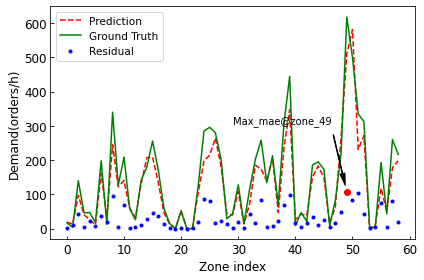

Saving figure evening_peak


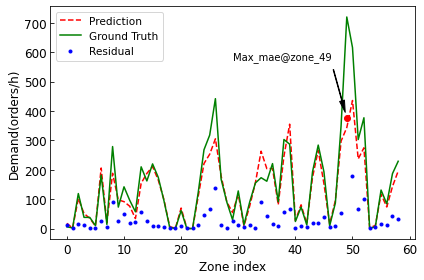

Saving figure pingfeng


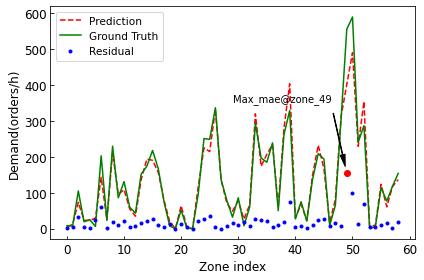

In [99]:
zone_curve(pred_,gt_,0,2,'morining_peak')
zone_curve(pred_,gt_,1,2,'evening_peak')
zone_curve(pred_,gt_,2,0,'pingfeng')

In [115]:
#可视化解释性注意力矩阵
import matplotlib.ticker as ticker
att_matrix = [tsi,tso,zsd,zst,tin]

In [208]:
def save_pc(data,len_zone_1,len_zone_2):
  for i in range(data.shape[0]):
    fig = plt.figure()
    ax = fig.gca()
    # ax = fig.add_subplot(int('22{}'.format(i+1)))
    cax = ax.matshow(data[i].T, interpolation='nearest', cmap='hot_r')
    fig.colorbar(cax)
    tick_spacing = 5
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(['t_{}'.format((i-1)*tick_spacing) for i in range(len_zone_1)],fontsize=8)
    ax.set_yticklabels(['t_{}'.format((i-1)*tick_spacing+47) for i in range(len_zone_2)],fontsize=8)
    save_fig('int{}'.format(i))
    plt.show()

Saving figure int0


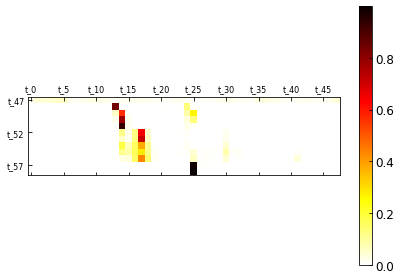

Saving figure int1


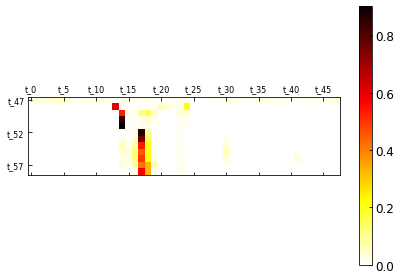

Saving figure int2


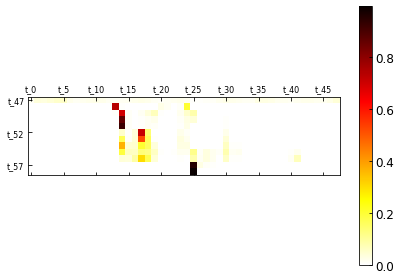

Saving figure int3


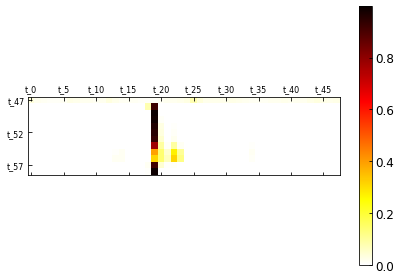

In [209]:
zst_ = att_matrix[4].reshape(-1,4,59,48,12)[0,:,2,:,:]
save_pc(zst_,12,48)

In [215]:
zsd_ = att_matrix[2].reshape(-1,4,12,59,59)[0,:,2,:,:]
zsd_ = zsd_[0].T
zone_pair = np.where(zsd_>=0.025)
zone_pair

(array([21, 22, 22, 49, 50, 51]), array([21, 21, 22, 50, 50, 49]))

In [216]:
for i,j in zip(zone_pair[0],zone_pair[1]):
  if i!=j:
    print((i,j))

(22, 21)
(49, 50)
(51, 49)


In [ ]:
# #打印计算图节点名称
# tensor_name_list = [tensor.name for tensor in graph.as_graph_def().node]
# for tensor_name in tensor_name_list[:5000]:
#     print(tensor_name)